In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plot
from image_utils import label_images, plot_images, count_samples

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Model, Sequential, models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input

np.random.seed(6)

In [10]:
# # verify if tensorflow is running with GPU
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# # check if keras is using GPU
print(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0']


## Define data, sample size, and image parameters

In [11]:
# define datasets
train_data_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train/"
test_data_dir = "/kaggle/input/intel-image-classification/seg_test/seg_test/"
pred_dir = "/kaggle/input/intel-image-classification/seg_pred/seg_pred/"
 
# define datasets and sample size
num_train_samples = count_samples(train_data_dir)
num_test_samples = count_samples(test_data_dir)

# define image dimensions
img_width, img_height = 150, 150
img_target_size = (img_width, img_height)

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [12]:
# training_imgs, labeled_training_imgs = label_images(train_data_dir, '.jpg')
# plot_images(training_imgs, labeled_training_imgs)

## Define hyperparameters and data generators

In [22]:
# define model hyperparameters
epochs = 50
batch_size = 64
neurons_per_layer = [2048, 1024, 512]
dropout = 0.5
n_classes = 6
patience = 3

# specify image augmentation
img_augmentation = ImageDataGenerator(preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True)

# prepare train/test data generators
train_data = img_augmentation.flow_from_directory(
    train_data_dir,
    target_size = img_target_size,
    batch_size = batch_size,
    class_mode = 'categorical')

test_data = img_augmentation.flow_from_directory(
    test_data_dir,
    target_size = img_target_size,
    batch_size = batch_size,
    class_mode = 'categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Create and train model

In [23]:
# specify base model and freeze weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# create model function
def create_model(base_model, dropout, neurons_per_layer, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = layers.Flatten()(x)
    
    for i, num_neurons in enumerate(neurons_per_layer, 1):
        x = layers.Dense(num_neurons, activation='relu')(x)
        
        if i % 2 == 0:
            x = layers.Dropout(dropout)(x)

    classifications = layers.Dense(num_classes, activation='softmax')(x) 
    model = Model(inputs=base_model.input, outputs=classifications)
    
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['acc'])

    return model

# instantiate model
model = create_model(base_model, dropout=dropout, neurons_per_layer=neurons_per_layer, num_classes=n_classes)

29089792/29084464 [==============================] - 1s 0us/step


In [27]:
callbacks = [EarlyStopping(monitor='val_loss', patience=patience), 
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)]

# train model
history = model.fit_generator(
    train_data,
    steps_per_epoch = num_train_samples // batch_size,
    validation_data = test_data,
    validation_steps = num_test_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    verbose = 1,
    use_multiprocessing = True)

Epoch 1/50
219/219 [==============================] - 133s 606ms/step - loss: 1.2241 - acc: 0.6938 - val_loss: 0.7088 - val_acc: 0.7714
Epoch 2/50
219/219 [==============================] - 128s 586ms/step - loss: 0.5531 - acc: 0.8054 - val_loss: 0.5152 - val_acc: 0.8006
Epoch 3/50
219/219 [==============================] - 130s 595ms/step - loss: 0.5107 - acc: 0.8209 - val_loss: 0.4982 - val_acc: 0.8132
Epoch 4/50
219/219 [==============================] - 130s 594ms/step - loss: 0.4624 - acc: 0.8372 - val_loss: 0.4602 - val_acc: 0.8230
Epoch 5/50
219/219 [==============================] - 130s 593ms/step - loss: 0.4412 - acc: 0.8359 - val_loss: 0.5087 - val_acc: 0.8159
Epoch 6/50
218/219 [============================>.] - ETA: 0s - loss: 0.4390 - acc: 0.8417
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
219/219 [==============================] - 131s 598ms/step - loss: 0.4387 - acc: 0.8417 - val_loss: 0.4883 - val_acc: 0.8349
Epoch 7/50
219/219 [===

## Plot training vs val accuracy

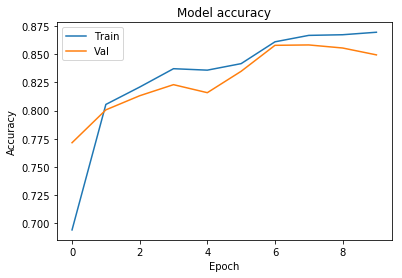

In [29]:
plot.plot(history.history['acc'])
plot.plot(history.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Val'], loc='upper left')
plot.show()

## Evaluate model on test data

In [ ]:
test_score = model.evaluate_generator(test_data,
    steps = num_test_samples // batch_size,
    verbose=1,
    use_multiprocessing=True)

print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))